In [1]:
import pandas as pd
import numpy as np
import scipy
from tqdm.notebook import tqdm
tqdm.pandas()
from collections import Counter
from pprint import pprint
import os, pickle, re, string

from matplotlib import pyplot as plt
import seaborn as sns

import plotly.express as px

C:\Users\puayn\Anaconda3\envs\foresky_data_explorer\lib\site-packages\tqdm\std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Combine data files

In [2]:
DATA_DIR = "data/"

In [3]:
# Concat all data files
combined_names_df = []
for filename in tqdm(os.listdir(DATA_DIR)):
    if filename.startswith("yob"):
        year = int(re.match("yob(.+)\.txt", filename).groups(0)[0])
        curr_names_df = pd.read_csv(DATA_DIR + filename, names=["name", "gender", "count"])
        curr_names_df["year"] = year
        combined_names_df.append(curr_names_df)
combined_names_df = pd.concat(combined_names_df)

### Data cleanliness checks

In [253]:
# Check for null values
null_value_check = np.sum(combined_names_df.isna())
print(f"Null value check:\n{null_value_check}\n")

Null value check:
name      0
gender    0
count     0
year      0
dtype: int64



In [249]:
# Check that gender is {"M", "F"}
gender_counts = combined_names_df['gender'].unique()
print(f"Gender sanity check:\n{gender_counts}\n")

Gender sanity check:
['F' 'M']



In [250]:
# Check that each year's names are unique
name_count_by_year_and_gender = combined_names_df.groupby(["year", "gender"])["name"].value_counts()
name_count_by_year_and_gender_check = sum(name_count_by_year_and_gender.values != 1) == 0
print(f"Check that each year's names (by gender) are unique:\n{name_count_by_year_and_gender_check}\n")

Check that each year's names (by gender) are unique:
True



In [367]:
# Check that count is >=5 (According to data source, names with count <5 are excluded from dataset)
names_count_check = sum(combined_names_df["count"] < 5) == 0
print(f"Check that all count are <5:\n{names_count_check}\n")

Check that all count are <5:
True



In [252]:
# Check no gap in year
years = sorted(combined_names_df["year"].unique())
print(
    f"Earliest year: {years[0]}, " + 
    f"Latest year: {years[-1]}, " + 
    f"Every year has data: {(years[-1] - years[0] + 1) == len(years)}"
)

Earliest year: 1880, Latest year: 2019, Every year has data: True


In [268]:
# Check name format
print("Check all names are a) lowercase except first letter b) have no spacing at start/end")
print(sum(combined_names_df["name"].apply(lambda name: 
                                          name.lower().capitalize() != name and 
                                          name.strip() == name))
      == 0)

Check all names are a) lowercase except first letter b) have no spacing at start/end
True


In [287]:
# Check name uniqueness
print("Check that names for each year are unique")
print(np.sum(combined_names_df.groupby(["year", "gender", "name"]).count().values != 1) == 0)

Check that names for each year are unique
True


In [302]:
# Check for special characters
print("Check for non-alpha characters")
charset = set()
for name in set(combined_names_df["name"]):
    charset.update(name.lower())
print(charset - set(string.ascii_lowercase))

Check for non-alpha characters
set()


#### Check length of names
Names seems fine, no anomaly. And these names have small counts relative to length 6 names

In [352]:
# Check length of names
names_stats = {name: {"length":len(name), "count":count} for name, count in combined_names_df.groupby("name")["count"].sum().iteritems()}
names_stats = pd.DataFrame.from_dict(names_stats, orient="index")

names_len_counter = Counter(names_stats["length"])
pprint(sorted(names_len_counter.items()))

[(2, 151),
 (3, 987),
 (4, 5472),
 (5, 16850),
 (6, 27688),
 (7, 25717),
 (8, 14200),
 (9, 5492),
 (10, 1777),
 (11, 640),
 (12, 230),
 (13, 138),
 (14, 66),
 (15, 36)]


In [364]:
# Stats for name of mode length
names_stats.query("length==6").sort_values(by="count", ascending=False)

,length,count
Robert,6,4845266
Joseph,6,2633323
Thomas,6,2327070
Daniel,6,1937717
George,6,1480476
...,...,...
Kasius,6,5
Taybor,6,5
Kasimu,6,5
Kasian,6,5


In [368]:
# Length ranges from 2 to 15. Let's look through 2/3/14/15 letter names, and their counts
names_stats.query("length==2").sort_values(by="count", ascending=False)

,length,count
Jo,2,180654
Ty,2,46216
Ed,2,26350
Al,2,17260
Bo,2,11892
...,...,...
Oh,2,5
Od,2,5
Ng,2,5
Mr,2,5


### Transform features

In [4]:
combined_names_df.head()

,name,gender,count,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [18]:
# Count as a pct of total count (each gender)
total_count_per_year_gender = combined_names_df.groupby(["year", "gender"])["count"].sum()
combined_names_df["pct_gender"] = combined_names_df.groupby(["year", "gender"])["count"].transform(lambda row: row / total_count_per_year_gender.loc[row.name[0], row.name[1]] * 100)

# Count as a pct of total count (both genders)
total_count_per_year = combined_names_df.groupby(["year"])["count"].sum()
combined_names_df["pct_total"] = combined_names_df.groupby(["year"])["count"].transform(lambda row: row / total_count_per_year.loc[row.name] * 100)

In [21]:
# Save file
combined_names_df["name"] = combined_names_df["name"].apply(lambda name: name.lower())
combined_names_df.to_csv("data/data_mod/names_combined.csv", index=False)

### Explore data

#### Num. males vs females over time

In [51]:
# Num males vs females, by year
count_by_gender_and_year = combined_names_df.groupby(["gender","year"])["count"].sum()

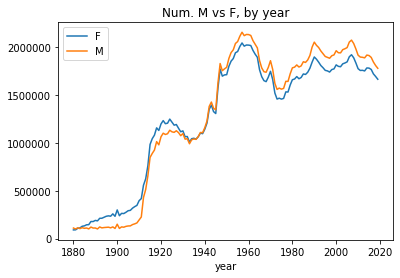

In [65]:
sns.lineplot(count_by_gender_and_year["F"].index, count_by_gender_and_year["F"].values)
sns.lineplot(count_by_gender_and_year["M"].index, count_by_gender_and_year["M"].values)
plt.legend(["F","M"])
plt.title("Num. M vs F, by year");

#### Look at top N names by gender and year

In [232]:
top_n_names_by_gender_year = combined_names_df.groupby(["gender", "year"]).apply(lambda e: e.head(10).sort_values(by="pct"))

In [233]:
top_n_names_by_gender_year

name gender  count  year       pct
gender year                                              
F      1880 9         Sarah      F   1288  1880  1.415478
            8        Bertha      F   1320  1880  1.450645
            7         Alice      F   1414  1880  1.553949
            6           Ida      F   1472  1880  1.617689
            5      Margaret      F   1578  1880  1.734180
...                     ...    ...    ...   ...       ...
M      2019 17909    Elijah      M  13300  2019  0.747213
            17908   William      M  13542  2019  0.760809
            17907    Oliver      M  13891  2019  0.780416
            17906      Noah      M  19048  2019  1.070144
            17905      Liam      M  20502  2019  1.151831

[2800 rows x 5 columns]

In [234]:
print(max(top_n_names_by_gender_year.query("gender=='M'")["pct"]))
print(max(top_n_names_by_gender_year.query("gender=='F'")["pct"]))

8.738347361752195
7.764248192188496


In [235]:
fig = px.bar(top_n_names_by_gender_year.query("gender=='M'"), x="pct", y="name", animation_frame="year", animation_group="name", orientation="h", range_x=[0,10])
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200
fig.show()

In [236]:
fig = px.bar(top_n_names_by_gender_year.query("gender=='F'"), x="pct", y="name", animation_frame="year", animation_group="name", orientation="h", range_x=[0,10])
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200
fig.show()

In [371]:
px.line(combined_names_df.query("name=='Richard' and gender=='M'"), x="year", y="pct")

In [369]:
fig = px.line(combined_names_df.query("name=='Linda' and gender=='F'"), x="year", y="pct")